In [1]:
import json
from datetime import date
from datetime import datetime,timedelta
import plotly.figure_factory as ff
from copy import deepcopy
import re
import numpy as np
import matplotlib.pyplot as plt
from os import path
%matplotlib inline

In [2]:
#JUST CHANGE THIS CELL AND RUN ALL OTHERS Experiment 1 = Static Scheduling for Transformer, Experiment 2 = Clustering v/s Eager, Experiment 3 = Clustering v/s HEFT
HOME = "./desktop/"
PREFIX = ""
EXPERIMENT = 1 #any one of 1,2,3 

In [3]:
if EXPERIMENT == 1:
    expt = ""
else:
    folder = "Expt-2"
    if EXPERIMENT == 2:
        heft_version = "eager"
    elif EXPERIMENT == 3:
        heft_version = "dynamic"

In [4]:
def create_relative_timestamps(size,num_queues_gpu=0,num_queues_cpu=0,num_heads_on_cpu=0,dag="transformer",heft=False,heft_version="eager"):
    timestamps=None
    if not heft:
        if num_queues_gpu==1 and num_queues_cpu==1:
            if dag=="transformer":
                size = 2**size
            filename=None
            filename = PREFIX+HOME+"final_cq_experiments/coarse/coarse_{}_{}.json".format(dag,size)
            with open(filename) as f:
                timestamps = json.load(f)
        else:
            if dag=="transformer":
                size = 2**size
            filename = PREFIX+HOME+"final_cq_experiments/q_assignment_{}_{}_{}.json".format(dag,size,num_heads_on_cpu)
#             print "Opening ",filename
            with open(filename) as f:
                timestamps = json.load(f)

        
       
  
#     else:
#         num_heads=0
#         if dag=="transformer":
#             size = 2**size
#             num_heads=16
#         if dag=="siamese":
#             num_heads=2
#         if dag=="resnext":
#             num_heads=32
        
            
            
    elif heft_version == "eager":
        num_heads=0
        if dag=="transformer":
            size = 2**size
            num_heads=16
        if dag=="siamese":
            num_heads=2
        if dag=="resnext":
            num_heads=32
        filename = PREFIX+HOME+"coarse_experiments/eager_{}_{}_with_delays.json".format(dag,size)
        print "Opening",filename
        with open(filename) as f:
            timestamps = json.load(f)
    elif heft_version == "dynamic":
        num_heads=0
        if dag=="transformer":
            size = 2**size
            num_heads=16
        if dag=="siamese":
            num_heads=2
        if dag=="resnext":
            num_heads=32
        filename = PREFIX+HOME+"coarse_experiments/dheft_{}_{}_with_delays.json".format(dag,size)
        print "Opening ",filename
        with open(filename) as f:
            timestamps = json.load(f)

    kernels = timestamps.keys()
    reference_device = {}
    reference_host = {}
    total_time = 0
    global_reference = None

    for kernel in kernels:
        device = timestamps[kernel]["device"]
        if device == 'gpu':
            t = timestamps[kernel]["write"]["device_start"]
        else:
            t = timestamps[kernel]["nd_range"]["device_start"]
        if t == -1:
            continue
        if not (device in reference_device):
            reference_device[device] = t
        else:
            reference_device[device] = min(reference_device[device],t)

        t = timestamps[kernel]["write"]["host_queued_end"]

        if not (device in reference_host):
            reference_host[device] = t
        else:
            reference_host[device] = min(reference_host[device],t)

        t = timestamps[kernel]["write"]["host_queued_start"]
        #print timestamps[kernel]["write"]["host_queued_end"]-timestamps[kernel]["write"]["host_queued_start"]
        if not global_reference:
            global_reference = t
        else:
            global_reference = min(global_reference,t)

    relative_timestamps = deepcopy(timestamps)

    # global_reference = None

    # for key,value in reference_host.items():
    #     if not global_reference:
    #         global_reference = value
    #     else:
    #         global_reference = min(value,global_reference)


    for kernel,kernel_timestamps in relative_timestamps.items():
        device = kernel_timestamps["device"]
        for event_type,event_timestamps in kernel_timestamps.items():
            #print(event_type)
            if event_type in ["device","cmdq"]:
                continue
            else:
                #continue
                for sub_event_type in event_timestamps:
                    if  sub_event_type[:4] == "host":
                        event_timestamps[sub_event_type] -= global_reference
                        continue
                    else:
                       event_timestamps[sub_event_type] = event_timestamps[sub_event_type] - reference_device[device] + reference_host[device] - global_reference
    #                     event_timestamps[sub_event_type] = event_timestamps[sub_event_type] - reference_device[device] + \
    #                     kernel_timestamps["write"]["host_queued_start"] - global_reference
                    total_time = max(total_time,event_timestamps[sub_event_type])



    #print "Total Time Taken - ",total_time
    #print(json.dumps(relative_timestamps,sort_keys=True,indent=1))          
    return total_time,relative_timestamps

In [5]:
HOME="./cluster/"
def get_queues(dag,size,num_heads_on_cpu,key):
    if dag=="transformer":
        size=2**size
    filename = PREFIX+HOME+"setup_cq_experiments/q_assignment_{}_{}_{}.stats".format(dag,size,num_heads_on_cpu)
    queues={'cpu':0,'gpu':0}
    contents=open(filename,'r').readlines()
    for line in contents:
        dtype,num_queues=line.strip("\n").split(",")
        queues[dtype]=num_queues
    return int(queues[key])

def get_enq_times(dag,size,num_heads_on_cpu):
    if dag=="transformer":
        size=2**size
    filename = PREFIX+HOME+"setup_cq_experiments/q_assignment_{}_{}_{}.time".format(dag,size,num_heads_on_cpu)
#     print "Opening ",filename
    queues={'cpu':0,'gpu':0}
    contents=open(filename,'r').readlines()
    total_time=0.0
    for line in contents:
#         print line
        dtype,num_queues=line.strip("\n").split(",")
        total_time+=float(num_queues)
    return total_time

# get_queues("siamese",64,2,'cpu')
# get_enq_times("transformer",7,1)



In [6]:
def get_best_time(dag,size,num_heads):
    
    gains = []
    sizes = []
    gpu_queues = []
    cpu_queues = []
    best_times = []

   

    ul=num_heads    
    min_time = None
    min_config = {}
    all_configs = {}

    default,_ = create_relative_timestamps(size,num_queues_gpu=1,num_queues_cpu=1,num_heads_on_cpu=0,dag=dag)
    for num_heads_on_cpu in range(0,ul):
        try:
            total_time,_ = create_relative_timestamps(size,num_heads_on_cpu=num_heads_on_cpu,dag=dag)
#             print "Individual",dag,size,num_heads_on_cpu,total_time
            all_configs[(size,num_heads_on_cpu)] = total_time
            if (not min_time) or (total_time<min_time):
                min_time = total_time
                min_config['num_heads_on_cpu'] = num_heads_on_cpu
                min_config['num_queues_gpu'] = get_queues(dag,size,num_heads_on_cpu,'gpu')
                min_config['num_queues_cpu'] = get_queues(dag,size,num_heads_on_cpu,'cpu')
#                 min_config['enq_time']=get_enq_times(dag,size,num_heads_on_cpu)

            #print "Num Queues - GPU {} CPU {} CPU Heads {}/{} Total Time {}".format(num_queues_gpu,num_queues_cpu,num_heads_on_cpu,size,total_time)
        except KeyboardInterrupt:
            raise KeyboardInterrupt
        except Exception as e:
            raise e
            #print "Best Configuration for size {} is {}, %gain {}".format(size,min_config,100.0*(default-min_time)/default)
            #raise e
    gain = 100.0*(default-min_time)/default

#     if EXPERIMENT==1:
#         print "Best Configuration for number of heads {} and size {} is {}, %gain {}".format(num_heads,size,min_config,gain)
#     else:
#         print "Best Configuration for size {} and number of heads 16 is {}, %time {}".format(2**size,min_config,min_time)

    
    
    best_time = min_time
    gpu_queues = min_config['num_queues_gpu']
    cpu_queues = min_config['num_queues_cpu']
    final_heads_on_cpu = min_config['num_heads_on_cpu']
#     enq_time = min_config['enq_time']
#     print dag,size,num_heads, final_heads_on_cpu, gpu_queues,cpu_queues, gain,(enq_time/best_time)*100,"%"
    print dag,size,num_heads, final_heads_on_cpu, gpu_queues,cpu_queues, default,best_time, gain
    return final_heads_on_cpu,gpu_queues,cpu_queues,float(default)/best_time,best_time,default

In [7]:
workloads = ["siamese", "transformer" , "resnext"]
# workloads = ["resnext"]
# home=["./cluster/"]
home = ["./desktop/","./cluster/"]
HOME = "./desktop/"
best_time_config = {}
print "dag     size total_subdags subdags_on_cpu  ngpu ncpu gain algo"
for h in home:
    print h
    HOME=h
    for workload in workloads:
        if workload=="transformer":
            for size in [6,7,8,9]:
                best_time_config[(h,workload,size)]=get_best_time("transformer",size,16)
        if workload=="siamese":
            for size in [64,128,256]:
                best_time_config[(h,workload,size)]=get_best_time("siamese",size,2)
        if workload=="resnext":
            for size in [64,128,256]:
                best_time_config[(h,workload,size)]=get_best_time("resnext",size,32)
# print best_time_config
    

dag     size total_subdags subdags_on_cpu  ngpu ncpu gain algo
./desktop/
siamese 64 2 0 3 0 0.00553464889526 0.00550103187561 0.60739209098
siamese 128 2 0 3 0 0.00616812705994 0.00606274604797 1.70847667272
siamese 256 2 0 3 0 0.00821685791016 0.00786590576172 4.27112349118
transformer 6 16 2 5 2 0.051210641861 0.0478324890137 6.59658368755
transformer 7 16 1 5 2 0.0715758800507 0.0636732578278 11.0409012328
transformer 8 16 1 5 2 0.173897504807 0.144001722336 17.1916109457
transformer 9 16 1 5 2 0.679745912552 0.598903179169 11.8930812073
resnext 64 32 0 3 0 0.374226093292 0.321209192276 14.1670775947
resnext 128 32 0 3 0 0.695518016815 0.585152864456 15.8680508183
resnext 256 32 3 3 2 1.32172656059 1.10415935516 16.4608332703
./cluster/
siamese 64 2 0 3 0 0.0124390125275 0.012241601944 1.58702777299
siamese 128 2 1 3 1 0.0146851539612 0.0146169662476 0.464330941325
siamese 256 2 1 3 1 0.0179741382599 0.0166325569153 7.46395362719
transformer 6 16 0 5 0 0.12570977211 0.0815200805664

In [11]:
# get mapping sensitivity
import numpy as np
def get_mapping_sensitivity(dag,size,num_heads,num_heads_on_cpu):
    
    gains = []
    sizes = []
    gpu_queues = []
    cpu_queues = []
    best_times = []

   

    ul=num_heads_on_cpu    
    min_time = None
    min_config = {}
    all_configs = {}
#     print dag,size
    default,_ = create_relative_timestamps(size,num_queues_gpu=1,num_queues_cpu=1,num_heads_on_cpu=0,dag=dag)

    all_times = []
    for num_queues_gpu in range(1,6):
        for num_queues_cpu in range(1,6):
            try:
                total_time,_ = create_relative_timestamps(size,num_queues_gpu,num_queues_cpu,num_heads_on_cpu,dag=dag)
                print num_heads_on_cpu,num_queues_cpu,num_queues_gpu,total_time
                all_configs[(size,num_queues_cpu,num_queues_gpu,num_heads_on_cpu)] = total_time
                all_times.append(total_time)


                #print "Num Queues - GPU {} CPU {} CPU Heads {}/{} Total Time {}".format(num_queues_gpu,num_queues_cpu,num_heads_on_cpu,size,total_time)
            except KeyboardInterrupt:
                raise KeyboardInterrupt
            except Exception as e:
                raise e
                #print "Best Configuration for size {} is {}, %gain {}".format(size,min_config,100.0*(default-min_time)/default)
                #raise e
    st = np.std(all_times)
#     print "Variance for num_heads on cpu {}: {}".format(num_heads_on_cpu,st)
    return st


    

In [74]:
print best_time_config
workloads = ["siamese", "transformer" , "resnext"]
home = ["./desktop/","./cluster/"]
HOME = "./desktop/"
for h in home:
    print h
    HOME=h
    for workload in workloads:
        if workload=="transformer":
            for size in [6,7,8,9]:
                final_heads_on_cpu,_,_,_,_ = best_time_config[(h,workload,size)]
                get_mapping_sensitivity("transformer",size,16,final_heads_on_cpu)
        if workload=="siamese":
            for size in [64,128,256]:
                final_heads_on_cpu,_,_,_,_ = best_time_config[(h,workload,size)]
                get_mapping_sensitivity("siamese",size,2,final_heads_on_cpu)
        if workload=="resnext":
            for size in [64,128,256]:
                final_heads_on_cpu,_,_,_,_ = best_time_config[(h,workload,size)]
                get_mapping_sensitivity("resnext",size,32,final_heads_on_cpu)

{('./cluster/', 'siamese', 256): (1, 3, 1, 1.1906482038932371, 0.016632556915283203), ('./desktop/', 'transformer', 9): (1, 5, 2, 1.1157743168541814, 0.5989031791687012), ('./desktop/', 'siamese', 64): (0, 3, 0, 0.9965327438997963, 0.0055010318756103516), ('./desktop/', 'transformer', 7): (1, 5, 2, 1.111351169191021, 0.06367325782775879), ('./cluster/', 'transformer', 8): (4, 5, 5, 1.6219683432017276, 0.18558764457702637), ('./desktop/', 'transformer', 8): (1, 5, 2, 1.2118538975176618, 0.14400172233581543), ('./desktop/', 'transformer', 6): (2, 5, 2, 1.0559354812983492, 0.047832489013671875), ('./cluster/', 'resnext', 256): (19, 4, 2, 1.8135861155022628, 0.8581662178039551), ('./cluster/', 'siamese', 64): (0, 3, 0, 0.9846723147336645, 0.012241601943969727), ('./desktop/', 'siamese', 256): (0, 3, 0, 1.075715324927255, 0.00786590576171875), ('./desktop/', 'resnext', 128): (0, 3, 0, 1.190271885080485, 0.5851528644561768), ('./cluster/', 'transformer', 7): (3, 5, 5, 1.5694183062446536, 0.1

NameError: name 'get_mapping_sensitivity' is not defined

In [85]:
#compute utilization -- DEPRECATED -- DO NOT USE
def get_utilization(size,num_queues_gpu=1,num_queues_cpu=0,num_heads_on_cpu=0,dag="transformer",heft=False,heft_version="eager"):
        
    if not heft:
        folder="dumps_"+dag+"/"+"parameterised_"+dag+"_multiple_runs/"
#         print "Operating on folder",folder
        filename=HOME+"{4}/{2}_GPU{0}_CPU{1}_{3}.json".format(num_queues_gpu,num_queues_cpu,size,num_heads_on_cpu,folder)
#         if !path.exists(filename):
#             print filename
#             exit(-1)
        
        with open(HOME+"{4}/{2}_GPU{0}_CPU{1}_{3}.json".format(num_queues_gpu,num_queues_cpu,size,num_heads_on_cpu,folder)) as f:
            timestamps = json.load(f)
       
  
    else:
        size = 2**size
        if heft_version == "eager":
            with open("./eager_heft/eager_siamese_128_with_delays.json") as f:
                timestamps = json.load(f)
        elif heft_version == "dynamic":
            with open("./dynamic_heft/dheft_siamese_128_with_delays.json") as f:
                timestamps = json.load(f)

    kernels = timestamps.keys()
    reference_device = {}
    reference_host = {}
    total_time = 0
    global_reference = None
    utilization = {'copy':[],'gpu':[],'cpu':[]} 
    for kernel in kernels:
        device = timestamps[kernel]["device"]
        if device == 'gpu':
            t = timestamps[kernel]["write"]["device_start"]
            copy_start = timestamps[kernel]["write"]["device_start"]
            copy_end = timestamps[kernel]["write"]["device_end"]
            device_start = timestamps[kernel]["nd_range"]["device_start"]
            device_end = timestamps[kernel]["write"]["device_end"]
            if(copy_start!=-1 and copy_end!=-1):
                utilization['copy'].append((copy_start,copy_end))
            utilization['gpu'].append((device_start,device_end))
        else:
            t = timestamps[kernel]["nd_range"]["device_start"]
            device_start = timestamps[kernel]["nd_range"]["device_start"]
            device_end = timestamps[kernel]["write"]["device_end"]
            utilization['cpu'].append((device_start,device_end))
        if t == -1:
            continue
        if not (device in reference_device):
            reference_device[device] = t
        else:
            reference_device[device] = min(reference_device[device],t)

        t = timestamps[kernel]["write"]["host_queued_end"]

        if not (device in reference_host):
            reference_host[device] = t
        else:
            reference_host[device] = min(reference_host[device],t)

        t = timestamps[kernel]["write"]["host_queued_start"]
        #print timestamps[kernel]["write"]["host_queued_end"]-timestamps[kernel]["write"]["host_queued_start"]
        if not global_reference:
            global_reference = t
        else:
            global_reference = min(global_reference,t)

    relative_timestamps = deepcopy(timestamps)

  

    for kernel,kernel_timestamps in relative_timestamps.items():
        device = kernel_timestamps["device"]
        for event_type,event_timestamps in kernel_timestamps.items():
            #print(event_type)
            if event_type in ["device","cmdq"]:
                continue
            else:
                #continue
                for sub_event_type in event_timestamps:
                    if  sub_event_type[:4] == "host":
                        event_timestamps[sub_event_type] -= global_reference
                        continue
                    else:
                       event_timestamps[sub_event_type] = event_timestamps[sub_event_type] - reference_device[device] + reference_host[device] - global_reference
    #                     event_timestamps[sub_event_type] = event_timestamps[sub_event_type] - reference_device[device] + \
    #                     kernel_timestamps["write"]["host_queued_start"] - global_reference
                    total_time = max(total_time,event_timestamps[sub_event_type])


    
    
    total_time_copy = 0
    min_start_time = float("inf")
    max_end_time = 0.0
    for u in utilization['copy']:
        total_time_copy += u[1]-u[0]
        min_start_time = min(min_start_time,u[0])
        max_end_time = max(max_end_time,u[1])
    actual_time_copy = max_end_time - min_start_time
        
    
#     print total_time_copy,actual_time_copy
    
    #print "Total Time Taken - ",total_time
    #print(json.dumps(relative_timestamps,sort_keys=True,indent=1))          
    return total_time,relative_timestamps


In [8]:
def get_utilization(size=64,num_queues_gpu=0,num_queues_cpu=0,num_heads_on_cpu=0,dag="siamese"):
    total_time,relative_timestamps=create_relative_timestamps(size,num_queues_gpu,num_queues_cpu,num_heads_on_cpu,dag)
    
    h2d_timing_information = []
    d2h_timing_information = []
    gpu_timing_information = []
    cpu_timing_information = []
    for kernel,kernel_timestamps in relative_timestamps.items():
        
        device = kernel_timestamps["device"]
        for event_type,event_timestamps in kernel_timestamps.items():
            if event_type in ["device","cmdq"]:
                continue
            else:
                if device=="gpu":
                    if event_type =="write":
                        if event_timestamps["device_start"]>=0 and event_timestamps["device_end"]>=0:
                            h2d_timing_information.append((kernel,event_timestamps["device_start"],event_timestamps["device_end"]))
    #                         print kernel,device
    #                         print(h2d_timing_information[-1])
                    if event_type =="read":
                        if event_timestamps["device_start"]>=0 and event_timestamps["device_end"]>=0:
                            d2h_timing_information.append((kernel,event_timestamps["device_start"],event_timestamps["device_end"]))
                    if event_type =="nd_range":
                        gpu_timing_information.append((kernel,event_timestamps["device_start"],event_timestamps["device_end"]))
#                         print kernel,device
#                         print gpu_timing_information[-1]
                        #if event_timestamps["device_start"]>=0 and event_timestamps["device_end"]>=0:
                         #   d2h_timing_information.append((event_timestamps["device_start"],event_timestamps["device_end"]))

                if device=="cpu":
                    if event_type =="nd_range":
                        cpu_timing_information.append((kernel,event_timestamps["device_start"],event_timestamps["device_end"]))
#                         print kernel,device
#                         print cpu_timing_information[-1]
                        
    return gpu_timing_information,cpu_timing_information,h2d_timing_information,d2h_timing_information
    


In [9]:
def compute_overlap(size=64,num_queues_gpu=0,num_queues_cpu=0,num_heads_on_cpu=0,dag="siamese"):
    gpu_timing_information,cpu_timing_information,h2d_timing_information,d2h_timing_information = get_utilization(size,num_queues_gpu,num_queues_cpu,num_heads_on_cpu,dag)
    idle_time_cpu = 0.0
    idle_time_gpu = 0.0
    idle_cpu_max = 0.0
    idle_gpu_max = 0.0
#     print gpu_timing_information
    gpu_timing_information.sort(key = lambda x: x[1])
    final_cpu=None
    final_gpu=None
    if len(gpu_timing_information)>0:
        final_gpu = gpu_timing_information[-1][2]
#     print "GPU Idleness"
    for idx in range(0,len(gpu_timing_information)-1):
        idle = gpu_timing_information[idx+1][1]-gpu_timing_information[idx][2]
        if idle>=0:
            idle_time_gpu+=idle
            idle_gpu_max=max(idle_gpu_max,idle)
#             print idle
    cpu_timing_information.sort(key = lambda x: x[1])
    if len(cpu_timing_information)>0:
        final_cpu = cpu_timing_information[-1][2]
#     print "CPU Idleness"
    for idx in range(0,len(cpu_timing_information)-1):
        idle = cpu_timing_information[idx+1][1]-cpu_timing_information[idx][2]
        if idle>=0:
            idle_time_cpu+=idle
#             print idle
            idle_cpu_max=max(idle_cpu_max,idle)
#     print "TOTAL"
#     print "CPU Idle time: ",idle_time_cpu, "GPU Idle time: ",idle_time_gpu
#     print "MAX"
#     print "CPU Idle time: ",idle_cpu_max, "GPU Idle time: ",idle_gpu_max
    return idle_time_cpu,idle_time_gpu,final_cpu,final_gpu

In [16]:
import pandas as pd
pd.options.display.max_columns=None
workloads = ["siamese", "transformer" , "resnext"]
home = ["./desktop/","./cluster/"]
HOME = "./desktop/"
print "workload size ngpu ncpu speedup idle_cpu_fine, idle_gpu_fine, idle_gpu_coarse ratio"
results = {"platform" :[], "workload":[], "size":[] ,"ngpu": [], "ncpu" :[], "speedup":[], "idle_cpu_c":[],"idle_cpu_f":[], "idle_gpu_c":[], "idle_gpu_f": [], "idle_ratio":[],"idle_ratio_cpu":[],"idle_ratio_gpu":[]}
for h in home:
    print h
    HOME=h
    for workload in workloads:
        
        if workload=="transformer":
            for size in [6,7,8,9]:
                final_heads_on_cpu,ng,nc,sp,best_time,default_time = best_time_config[(h,workload,size)]
#                 st=get_mapping_sensitivity("transformer",size,16,final_heads_on_cpu)
                c1,g1,fc1,fg1=compute_overlap(size,num_queues_gpu=ng,num_queues_cpu=nc,num_heads_on_cpu=final_heads_on_cpu,dag="transformer")
                c2,g2,fc2,fg2=compute_overlap(size,num_queues_gpu=1,num_queues_cpu=1,num_heads_on_cpu=final_heads_on_cpu,dag="transformer")
                results["platform"].append(h)
                results["workload"].append(workload)
                results["size"].append(size)
                results["ngpu"].append(ng)
                results["ncpu"].append(nc)
                results["speedup"].append(sp)
                results["idle_cpu_c"].append(c2)
                results["idle_cpu_f"].append(c1)
                results["idle_gpu_c"].append(g2)
                results["idle_gpu_f"].append(g1)
                if final_heads_on_cpu == 0:
                    results["idle_ratio"].append(g2/g1)
                else:
                    results["idle_ratio"].append((g2+default_time)/(g1+c1))
                results["idle_ratio_gpu"].append((g2)/(g1))
                if final_heads_on_cpu > 0:
                    results["idle_ratio_cpu"].append(g2/(c1))
                else:
                    results["idle_ratio_cpu"].append(None)
                    
#                 results["mapping_sensitivity"].append(st)
                cpu_idle_ratio = None
                gpu_idle_ratio= None
                if(c1!=0 or fc1!=None):
                    cpu_idle_ratio=c1/fc1
                if(g1!=0 or g2!=None):
                    gpu_idle_ratio=g1/fg1
                
                print workload,size,ng,nc,sp,cpu_idle_ratio,gpu_idle_ratio,g2/fg2

        if workload=="siamese":
            for size in [64,128,256]:
                final_heads_on_cpu,ng,nc,sp,best_time,default_time = best_time_config[(h,workload,size)]
#                 st=get_mapping_sensitivity("siamese",size,2,final_heads_on_cpu)
                c1,g1,fc1,fg1=compute_overlap(size,num_queues_gpu=ng,num_queues_cpu=nc,num_heads_on_cpu=final_heads_on_cpu,dag="siamese")
                c2,g2,fc2,fg2=compute_overlap(size,num_queues_gpu=1,num_queues_cpu=1,num_heads_on_cpu=final_heads_on_cpu,dag="siamese")
                results["platform"].append(h)
                results["workload"].append(workload)
                results["size"].append(size)
                results["ngpu"].append(ng)
                results["ncpu"].append(nc)
                results["speedup"].append(sp)
                results["idle_cpu_c"].append(c2)
                results["idle_cpu_f"].append(c1)
                results["idle_gpu_c"].append(g2)
                results["idle_gpu_f"].append(g1)
                if final_heads_on_cpu == 0:
                    results["idle_ratio"].append(g2/g1)
                else:
                    results["idle_ratio"].append((g2+default_time)/(g1+c1))
                results["idle_ratio_gpu"].append((g2)/(g1))
                if final_heads_on_cpu > 0:
                    results["idle_ratio_cpu"].append(default_time/(c1))
                else:
                    results["idle_ratio_cpu"].append(None)
#                 results["mapping_sensitivity"].append(st)
                cpu_idle_ratio = None
                gpu_idle_ratio= None
                if(c1!=0 or fc1!=None):
                    cpu_idle_ratio=c2/c1
                if(g1!=0 or g2!=None):
                    gpu_idle_ratio=g2/g1
                print workload,size,ng,nc,sp,cpu_idle_ratio,gpu_idle_ratio,g2/fg2
                
        if workload=="resnext":
            for size in [64,128,256]:
                final_heads_on_cpu,ng,nc,sp,best_time,default_time = best_time_config[(h,workload,size)]
                
#                 st=get_mapping_sensitivity("resnext",size,32,final_heads_on_cpu)
                c1,g1,fc1,fg1=compute_overlap(size,num_queues_gpu=ng,num_queues_cpu=nc,num_heads_on_cpu=final_heads_on_cpu,dag="resnext")
                c2,g2,fc2,fg2=compute_overlap(size,num_queues_gpu=1,num_queues_cpu=1,num_heads_on_cpu=final_heads_on_cpu,dag="resnext")
                results["platform"].append(h)
                results["workload"].append(workload)
                results["size"].append(size)
                results["ngpu"].append(ng)
                results["ncpu"].append(nc)
                results["speedup"].append(sp)
                results["idle_cpu_c"].append(c2)
                results["idle_cpu_f"].append(c1)
                results["idle_gpu_c"].append(g2)
                results["idle_gpu_f"].append(g1)
                if final_heads_on_cpu == 0:
                    results["idle_ratio"].append(g2/g1)
                else:
                    results["idle_ratio"].append((g2+default_time)/(g1+c1))
                    print "DEBUG",g2,g1,default_time,c1
                results["idle_ratio_gpu"].append((g2)/(g1))
                if final_heads_on_cpu > 0:
                    results["idle_ratio_cpu"].append(default_time/(c1))
                else:
                    results["idle_ratio_cpu"].append(None)
#                 results["mapping_sensitivity"].append(st)
                cpu_idle_ratio = None
                gpu_idle_ratio= None
                if(c1!=0 or fc1!=None):
                    cpu_idle_ratio=c1/fc1
                if(g1!=0 or g2!=None):
                    gpu_idle_ratio=g1/fg1
                     
                print workload,size,final_heads_on_cpu,ng,nc,sp,cpu_idle_ratio,gpu_idle_ratio,g2/fg2

df = pd.DataFrame(results)
df = df[["platform","workload", "size", "ngpu", "ncpu", "speedup", "idle_ratio","idle_ratio_gpu","idle_ratio_cpu" ]]
df.style



workload size ngpu ncpu speedup idle_cpu_fine, idle_gpu_fine, idle_gpu_coarse ratio
./desktop/
siamese 64 3 0 1.00611103888 None 0.928527607362 0.130586712683
siamese 128 3 0 1.01738172952 None 1.25367019461 0.142132765628
siamese 256 3 0 1.04461687682 None 1.33291956306 0.156039293188
transformer 6 5 2 1.07062465109 0.000633024962118 0.0222397036891 0.0266399072423
transformer 7 5 2 1.12411210754 0.000985141429851 0.026052532032 0.0377218318892
transformer 8 5 2 1.20760711737 0.00198739289879 0.00720340596906 0.0750496390882
transformer 9 5 2 1.13498464559 0.000354875614078 0.00468862042042 0.0486084972261
resnext 64 0 3 0 1.1650541214 None 0.595045896841 0.655008398135
resnext 128 0 3 0 1.18860909527 None 0.620571295978 0.695352483269
DEBUG 0.935622215271 0.642241001129 1.32172656059 0.000171422958374
resnext 256 3 3 2 1.19704330214 0.000278309473167 0.623489797118 0.723851466984
./cluster/
siamese 64 3 0 1.01612620508 None 1.11912128713 0.0693682635879
siamese 128 3 1 1.00466497031 

,platform,workload,size,ngpu,ncpu,speedup,idle_ratio,idle_ratio_gpu,idle_ratio_cpu
0,./desktop/,siamese,64,3,0,1.00611,0.928528,0.928528,nan
1,./desktop/,siamese,128,3,0,1.01738,1.25367,1.25367,nan
2,./desktop/,siamese,256,3,0,1.04462,1.33292,1.33292,nan
3,./desktop/,transformer,6,5,2,1.07062,52.5283,1.40531,45.0472
4,./desktop/,transformer,7,5,2,1.12411,43.2086,1.6278,44.5787
5,./desktop/,transformer,8,5,2,1.20761,141.895,12.5818,46.54
6,./desktop/,transformer,9,5,2,1.13498,237.895,11.767,175.181
7,./desktop/,resnext,64,3,0,1.16505,1.34256,1.34256,nan
8,./desktop/,resnext,128,3,0,1.18861,1.40148,1.40148,nan
9,./desktop/,resnext,256,3,2,1.19704,3.51386,1.45681,7710.32


In [19]:
#Coarse Grained vs Fine Grained
coarse_vs_fine_results = {}
for h in home:
    print h
    HOME=h
    for workload in workloads:
        if workload=="transformer":
            for size in [6,7,8]:
                _,_,_,_,best_time,_ = best_time_config[(h,workload,size)]
                eager_time,_=create_relative_timestamps(size,dag=workload,heft=True,heft_version="eager")
                dheft_time,_=create_relative_timestamps(size,dag=workload,heft=True,heft_version="dynamic")
                coarse_vs_fine_results[(h,workload,size)]=best_time,eager_time,dheft_time
                
        if workload=="siamese":
            for size in [64,128,256]:
                _,_,_,_,best_time,_ = best_time_config[(h,workload,size)]
                eager_time,_=create_relative_timestamps(size,dag=workload,heft=True,heft_version="eager")
                dheft_time,_=create_relative_timestamps(size,dag=workload,heft=True,heft_version="dynamic")
                coarse_vs_fine_results[(h,workload,size)]=best_time,eager_time,dheft_time
        if workload=="resnext":
            workload_coarse="resnext"
            for size in [64,128,256]:
                _,_,_,_,best_time,_ = best_time_config[(h,workload,size)]
                eager_time,_=create_relative_timestamps(size,dag=workload_coarse,heft=True,heft_version="eager")
                dheft_time,_=create_relative_timestamps(size,dag=workload_coarse,heft=True,heft_version="dynamic")
                coarse_vs_fine_results[(h,workload,size)]=best_time,eager_time,dheft_time

./desktop/
Opening ./desktop/coarse_experiments/eager_siamese_64_with_delays.json
Opening  ./desktop/coarse_experiments/dheft_siamese_64_with_delays.json
Opening ./desktop/coarse_experiments/eager_siamese_128_with_delays.json
Opening  ./desktop/coarse_experiments/dheft_siamese_128_with_delays.json
Opening ./desktop/coarse_experiments/eager_siamese_256_with_delays.json
Opening  ./desktop/coarse_experiments/dheft_siamese_256_with_delays.json
Opening ./desktop/coarse_experiments/eager_transformer_64_with_delays.json
Opening  ./desktop/coarse_experiments/dheft_transformer_64_with_delays.json
Opening ./desktop/coarse_experiments/eager_transformer_128_with_delays.json
Opening  ./desktop/coarse_experiments/dheft_transformer_128_with_delays.json
Opening ./desktop/coarse_experiments/eager_transformer_256_with_delays.json
Opening  ./desktop/coarse_experiments/dheft_transformer_256_with_delays.json
Opening ./desktop/coarse_experiments/eager_resnext_64_with_delays.json
Opening  ./desktop/coarse_ex

siamese 64 0.00550103187561 0.0150547027588 0.0200529098511
siamese 128 0.00606274604797 0.0241839885712 0.0186107158661
siamese 256 0.00786590576172 0.036737203598 0.0339987277985
transformer 6 0.0478324890137 0.107419013977 0.104646444321
transformer 7 0.0636732578278 0.163958072662 0.133768081665
transformer 8 0.144001722336 0.388954162598 0.262097597122
resnext 64 0.321209192276 2.71548080444 2.09184718132
resnext 128 0.585152864456 5.24205851555 4.14674925804
resnext 256 1.10415935516 10.3810093403 8.24170851707


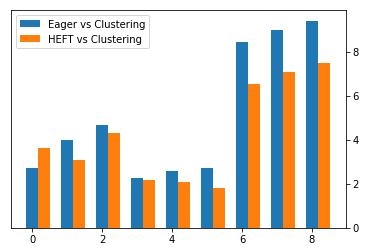

In [20]:
# for key in coarse_vs_fine_results:
#     h,workload,size=key
#     best_time,eager_time,dheft_time=coarse_vs_fine_results[key]
#     print h,workload,size,eager_time/best_time,dheft_time/best_time

eager_speedups = []
dheft_speedups = []
h="./desktop/"
HOME=h
for workload in workloads:
    if workload=="transformer":
        for size in [6,7,8]:
            best_time,eager_time,dheft_time=coarse_vs_fine_results[(h,workload,size)]
            eager_speedups.append(eager_time/best_time)
            dheft_speedups.append(dheft_time/best_time)
            print workload,size, best_time,eager_time,dheft_time

                
    if workload=="siamese":
        for size in [64,128,256]:
            best_time,eager_time,dheft_time=coarse_vs_fine_results[(h,workload,size)]
            eager_speedups.append(eager_time/best_time)
            dheft_speedups.append(dheft_time/best_time)
            print workload,size, best_time,eager_time,dheft_time

                
    if workload=="resnext":
        for size in [64,128,256]:
            best_time,eager_time,dheft_time=coarse_vs_fine_results[(h,workload,size)]
            eager_speedups.append(eager_time/best_time)
            dheft_speedups.append(dheft_time/best_time)
            print workload,size, best_time,eager_time,dheft_time

            
N=len(eager_speedups)
ind = np.arange(N) 
width = 0.35    

plt.bar(ind, eager_speedups, width, label='Eager vs Clustering')
plt.bar(ind + width, dheft_speedups, width,label='HEFT vs Clustering')
ax = plt.gca()
ax.yaxis.tick_right()
# ax.yaxis.set_label_position("right")
# plt.ylabel('Speedup')
# plt.xticks(ind + width / 2, ('G1', 'G2', 'G3', 'G4', 'G5'))
plt.legend(loc='best')

plt.savefig('desktop_bar.png', dpi=300, bbox_inches='tight')
plt.show()

    

In [98]:
#coarse experiments for aggregated resnext
h="./desktop/"
workload="resnext"
workload_revised="resnext"
for size in [64,128,256]:
    _,_,_,_,best_time = best_time_config[(h,workload,size)]
    eager_time,_=create_relative_timestamps(size,dag=workload_revised,heft=True,heft_version="eager")
    dheft_time,_=create_relative_timestamps(size,dag=workload_revised,heft=True,heft_version="dynamic")
    coarse_vs_fine_results[(h,workload,size)]=best_time,eager_time,dheft_time
    print size,best_time,eager_time,dheft_time
    

ValueError: too many values to unpack

siamese 64 0.012241601944 0.0613629817963 0.0726344585419
siamese 128 0.0146169662476 0.0653293132782 0.0652446746826
siamese 256 0.0166325569153 0.0625660419464 0.0629081726074
transformer 6 0.0815200805664 1.19505882263 1.10978055
transformer 7 0.100336074829 1.1784555912 1.05452227592
transformer 8 0.185587644577 1.04093980789 1.01703810692
resnext 64 0.278021097183 0.446012973785 0.511233568192
resnext 128 0.444513082504 0.672655105591 0.9064245224
resnext 256 0.809017896652 1.2496805191 1.50610661507


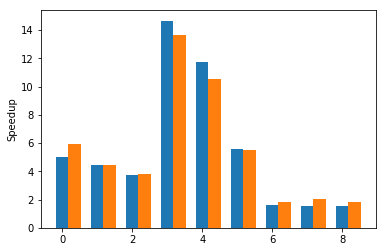

In [21]:
from matplotlib.ticker import MaxNLocator
eager_speedups = []
dheft_speedups = []
h="./cluster/"
HOME=h
for workload in workloads:
    if workload=="transformer":
        for size in [6,7,8]:
            best_time,eager_time,dheft_time=coarse_vs_fine_results[(h,workload,size)]
            eager_speedups.append(eager_time/best_time)
            dheft_speedups.append(dheft_time/best_time)
            print workload,size, best_time,eager_time,dheft_time

                
    if workload=="siamese":
        for size in [64,128,256]:
            best_time,eager_time,dheft_time=coarse_vs_fine_results[(h,workload,size)]
            eager_speedups.append(eager_time/best_time)
            dheft_speedups.append(dheft_time/best_time)
            print workload,size, best_time,eager_time,dheft_time

                
    if workload=="resnext":
        for size in [64,128,256]:
            best_time,eager_time,dheft_time=coarse_vs_fine_results[(h,workload,size)]
            eager_speedups.append(eager_time/best_time)
            dheft_speedups.append(dheft_time/best_time)
            print workload,size, best_time,eager_time,dheft_time

            
N=len(eager_speedups)
ind = np.arange(N) 
width = 0.35       
plt.bar(ind, eager_speedups, width, label='Eager vs Clustering')
plt.bar(ind + width, dheft_speedups, width,label='HEFT vs Clustering')
ax = plt.gca()
ax.yaxis.tick_left()
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

plt.ylabel('Speedup')
# plt.xticks(ind + width / 2, ('G1', 'G2', 'G3', 'G4', 'G5'))
# plt.legend(loc='best')
plt.savefig('cluster_bar.png', dpi=300, bbox_inches='tight')
plt.show()

    

In [38]:
#debug resnext
HOME="./cluster/"
dag="resnext"
folder="dumps_"+dag+"/"+"parameterised_"+dag+"_multiple_runs/"

for size in [64,128,256]:
    for num_queues_gpu in range(1,6):
        for num_queues_cpu in range(1,6):
            for num_heads_on_cpu in range(0,32):
                filename=HOME+"{4}/{2}_GPU{0}_CPU{1}_{3}.json".format(num_queues_gpu,num_queues_cpu,size,num_heads_on_cpu,folder)
                dump_filename="./profiling/"+"{4}/{2}_GPU{0}_CPU{1}_{3}.json".format(num_queues_gpu,num_queues_cpu,size,num_heads_on_cpu,folder)    
                if not path.exists(filename):
                    create_command ="python scheduling/create_resnext.py {} {} {}".format(size,num_heads_on_cpu,32)
                    command_header ="python scheduling/multiple_dag_devices.py -f ./dag_info/dag_resnext/ -ng {} -nc {} -rc -fdp \'{}\'".format(num_queues_cpu,num_queues_gpu,dump_filename)
                    copy_command = "scp anirban@10.5.30.11:~/ResearchTools/pyschedcl-anirban/pyschedcl-stable/pyschedcl/"+dump_filename[2:]
#                     print create_command
#                     print command_header
                    print copy_command
            


In [ ]:
#coarse experiments with resnext


In [16]:
dheft_time,_ = create_relative_timestamps(size,heft=True,heft_version="dynamic")
eager_time,_ = create_relative_timestamps(size,heft=True,heft_version="eager")
print dheft_time, eager_time
clustering_time = 0.00664258003235
speedup_dheft = dheft_time/clustering_time
speedup_eager = eager_time/clustering_time
print speedup_dheft, speedup_eager

0.0194914340973 0.0239727497101
2.93431678691 3.60895158106


In [ ]:
siamese 64 2 0.0062267780304 0.00568795204163 [2] [4] 8.65336753838
siamese 128 2 0.00678730010986 0.00664258003235 [2] [2] 2.13221863145
siamese 256 2 0.00902819633484 0.00841665267944 [3] [5] 6.77370797792
resnext 64 32 0.145850658417 0.145695924759 [2] [5] 0.10609047605
resnext 128 32 0.250016212463 0.242693662643 [5] [2] 2.92882999378
resnext 256 32 0.462659358978 0.443778753281 [2] [3] 4.08088701357

In [6]:
if folder == "Expt-2":
    heft_times = []
    for size in range(sl,su):
        total_time,_ = create_relative_timestamps(size,heft=True,heft_version=heft_version)
        heft_times.append(total_time)


sizes = np.array(sizes)
gains = np.array(gains)
gpu_queues = np.array(gpu_queues)
cpu_queues = np.array(cpu_queues)
if folder == 'Expt-2':
    heft_times = np.array(heft_times)
    best_times = np.array(best_times)
    speedups_over_heft = heft_times/best_times
    real_sizes = 2**sizes

In [7]:
if folder == 'Expt-2':
    plt.xlabel(r'Size of Transformer - $\beta$')
    plt.ylabel('Speedup')
    plt.plot(real_sizes,speedups_over_heft,'bo-')
    #plt.axvline(10.5,color='r',linestyle='dashed')
    #plt.title(r'Speedups over HEFT vs Size of Transformer')
    plt.xscale('log',basex=2)
    plt.xlim(32,1024)
    #plt.xticks(real_sizes)
    #plt.plot(sizes,cpu_queues,'ro-')


    for i in range(len(sizes)):
        x = real_sizes[i]
        y = speedups_over_heft[i]
        if x > 10:
            label =  str(gpu_queues[i])+","+str(cpu_queues[i])
        else:
            label = str(gpu_queues[i])+","+str(0)
        y_offset = 10 if i%2 else 10
        plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(-2.5,y_offset), # distance from text to points (x,y)
                     ha='center',
                     fontsize = 8,
                     label = 'cq_config') 
    

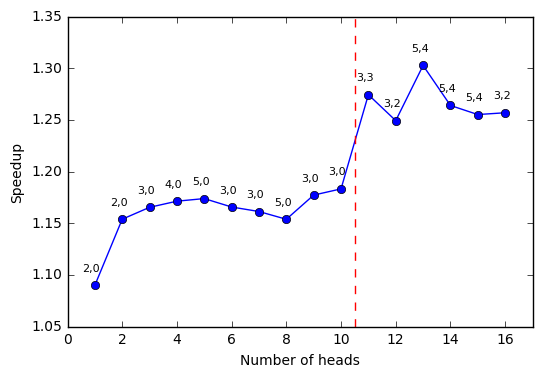

In [8]:
if folder == 'Expt-1':
    gains = np.array(gains)
    speedups = 1/(1-gains/100)
    plt.xlim(0,17)
    plt.xlabel('Number of heads')
    plt.ylabel('Speedup')
    plt.plot(sizes,speedups,'bo-')
    plt.axvline(10.5,color='r',linestyle='dashed')
    #plt.title('Speedups vs Number of Heads - (CQ_gpu, CQ_cpu)')
    #plt.plot(sizes,cpu_queues,'ro-')


    for i in range(len(sizes)):
        x = sizes[i]
        y = speedups[i]
        if x > 10:
            label =  str(gpu_queues[i])+","+str(cpu_queues[i])
        else:
            label = str(gpu_queues[i])+","+str(0)
        y_offset = 10 if i%2 else 10
        plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(-2.5,y_offset), # distance from text to points (x,y)
                     ha='center',
                     fontsize = 8,
                     label = 'cq_config') 


In [9]:
if folder == 'Expt-2':
    best_time,best_timestamps = create_relative_timestamps(size=9,num_queues_gpu=2,num_queues_cpu=2,num_heads_on_cpu=0,folder=folder)
    heft_time,heft_timestamps = create_relative_timestamps(size=9,heft=True,heft_version=heft_version)
    

In [10]:
def to_time_delta(timestamp):
    now = datetime.now()
    second = int(timestamp)
    microsecond = (timestamp - float(second))*1e6
    now = now.replace(hour=0, minute=0, second=second, microsecond=int(microsecond))
    return now


def plot_per_cq(relative_timestamps,total_time,title):
    df = []
    kernels = {}




    for kernel,events in relative_timestamps.items():
        dev = events["device"]
        cq = events["cmdq"]
        #print kernel,cq
        Task = "<b>{}_{}</b>".format(dev,cq)
        ##events -> write,read,nd_range
        ##event  -> device_queued,device_start,device-end
    #         for interval in intervals:
    #             Resource=event
    #             Start = now + timedelta(seconds=interval[0])
    #             Finish = now + timedelta(seconds=interval[1])
    #             df.append(dict(Task=Task,Start=Start,Finish=Finish,Resource=Resource))


        if events["write"]["device_start"] > 0:
            write_overhead_start = to_time_delta(events["write"]["host_queued_start"])
            write_event_start = write_overhead_end = to_time_delta(events["write"]["device_start"])
            write_event_end = to_time_delta(events["write"]["device_end"])
            #df.append(dict(Task=Task,Start=write_overhead_start,Finish=write_overhead_end,Resource='overhead'))
            df.append(dict(Task=Task,Start=write_event_start,Finish=write_event_end,Resource='<b>write</b>'))



        if kernel.startswith('FFC'):
            exec_resource = '<b>gemm</b>'
        elif "transpose" in kernel:
            exec_resource = '<b>transpose</b>'
        elif 'softmax' in kernel:
            exec_resource = '<b>softmax</b>'
        else:
            exec_resource = '<b>copy</b>'

        exec_event_start  = to_time_delta(events["nd_range"]["device_start"])
        exec_event_end = to_time_delta(events["nd_range"]["device_end"])
        df.append(dict(Task=Task,Start=exec_event_start,Finish=exec_event_end,Resource=exec_resource))


        if events["read"]["device_start"] > 0:
            read_event_start = to_time_delta(events["read"]["device_start"])
            read_overhead_start = read_event_end = to_time_delta(events["read"]["device_end"])
            df.append(dict(Task=Task,Start=read_event_start,Finish=read_event_end,Resource='<b>read</b>'))



    colors = {'<b>copy</b>': '#ff00ff',
              '<b>read</b>': (1, 0.9, 0.16),
              '<b>write</b>': 'rgb(0, 255, 100)',
             'overhead': 'rgb(0, 0, 255)',
             '<b>gemm</b>': '#dd3069',
             '<b>transpose</b>': '#a9a9d9',
             '<b>softmax</b>': '#3399cc'}

    df.sort(key = lambda x : x['Task'])
    fig = ff.create_gantt(df, colors=colors, index_col='Resource', show_colorbar=True,
                          group_tasks=True,width=1000,height=600)

    fig.layout['xaxis']['tickformat'] = '<b>%-S.%3f</b>'
    fig.layout['title'] = title
    fig.layout['xaxis_title'] = '<b>Time (seconds)</b>'
    fig.layout['yaxis_title'] = '<b>Command Queue</b>'
    #fig.layout['xaxis_range']=[to_time_delta(0),to_time_delta(total_time)]
    fig.layout['xaxis_range'] = [to_time_delta(0),to_time_delta(max(best_time,heft_time)+0.1)]
    #fig.layout['xaxis_range'] = [to_time_delta(0),to_time_delta(1.2)]
    #fig.layout['paper_bgcolor'] = 'rgb(255,255,255)'
    fig.layout['plot_bgcolor'] = 'rgb(255,255,255)'

    fig.layout['xaxis']['linecolor'] = 'rgb(0,0,0)'
    fig.layout['xaxis']['mirror'] =True
    fig.layout['xaxis']['ticks'] = 'outside'
    fig.layout['xaxis']['showline'] = True

    fig.layout['yaxis']['linecolor'] = 'rgb(0,0,0)'
    fig.layout['yaxis']['mirror'] =True
    fig.layout['yaxis']['ticks'] = 'outside'
    fig.layout['yaxis']['showline'] = True
    
    fig.layout['font'] = dict(
            family="Courier New, monospace",
            size=22,
            color="#000000")
    fig.update_traces(mode='lines', line_color='black',line_width=0.5,selector=dict(fill='toself'),dy=0.0001,dx=0.0001)

    
    fig.show()
    return fig

In [11]:
if folder == "Expt-2":
    fig = plot_per_cq(best_timestamps,best_time,'Cluster Sch. -  Total Time {0:.2f} s'.format(best_time))

In [12]:
if folder == "Expt-2":
    if EXPERIMENT == 2:
        title = "Eager Sch."
    else:
        title = "HEFT Sch."
    fig = plot_per_cq(heft_timestamps,heft_time,'{0} - Total Time {1:.2f} s'.format(title,heft_time))
        